In [1]:
#import
img_height, img_width = (256,256)# 输入图像尺寸
out_channel = 5# 输出频道数

print('over1')

# 导入必要的库
import os
import glob
import random
import sys
import shutil
import skimage.io
import skimage.transform
import numpy as np
import pandas as pd
import sklearn
#import pydot
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
print('over2')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.layers import MaxPooling2D, Permute
from tensorflow.keras.layers import Layer, Input, Lambda
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback


# 打印环境版本信息
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
#print('pydot        :', pydot.__version__)

over1
over2
Python       : 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
Numpy        : 1.23.5
Skimage      : 0.20.0
Scikit-learn : 1.1.3
Keras        : 2.4.0
Tensorflow   : 2.3.0


In [2]:
# 路径设置
'''
topDir = os.path.dirname(os.path.abspath(__file__))# 动态获取当前脚本的父目录
__file__是Python内置变量，表示当前脚本的绝对路径。但在交互式环境中，没有"当前脚本"的概念，因此该变量不存在
如果代码保存为.py文件并直接执行，__file__可以正常使用，但需添加路径修正逻辑
'''

#os.chdir()

codDir = os.getcwd()#获取代码所在文件夹
topDir = os.path.dirname(codDir)#获取代码所在文件夹的上一级文件夹
print('项目文件夹路径:',topDir)
codDir = os.path.join(topDir, "GP_code")
print('代码文件夹路径:',codDir)
imgDir = os.path.join(topDir, "GP_img")# 获取图片所在文件夹
print('图片文件夹路径:',imgDir)
weiDir = os.path.join(topDir, "GP_wei")# 获取权重所在文件夹
print('权重文件夹路径:',weiDir)

nor5Dir = os.path.join(weiDir, "nor5")
aug5Dir = os.path.join(weiDir, "aug5")
aug55Dir = os.path.join(weiDir, "aug55")
aug2Dir = os.path.join(weiDir, "aug2")
aug25Dir = os.path.join(weiDir, "aug25")

encoder_Dir = os.path.join(weiDir, "encoder")
decoder1_Dir = os.path.join(weiDir, "decoder1")
decoder2_Dir = os.path.join(weiDir, "decoder2")
fusion_Dir = os.path.join(weiDir, "fusion")

weiPre = "model-weights_pre.hdf5"#预训练权重名称
weiDur = "model-weights_dur.hdf5"#训练中权重名称
weiEnd = "model-weights_end.hdf5"#训练后权重名称

#encFile=os.path.join(encoder_Dir, weiDur)
#dec1File=os.path.join(aug55Dir, weiDur)
encFile=os.path.join(encoder_Dir, weiDur)
dec1File=os.path.join(decoder1_Dir, weiDur)
dec2File=os.path.join(decoder2_Dir, weiDur)
fusFile=os.path.join(fusion_Dir, weiDur)

print('encFile:', encFile)
print('dec1File:', dec1File)
#preDir = os.path.join(aug55Dir, weiPre)# 预训练权重保存目录
#workDir = os.path.join(aug55Dir, weiDur)# 权重动态保存目录
#endDIr = os.path.join(aug55Dir, weiEnd)# 训练结束权重保存目录

os.chdir(topDir)#不要重复运行该框
print('over')

项目文件夹路径: C:\project\python
代码文件夹路径: C:\project\python\GP_code
图片文件夹路径: C:\project\python\GP_img
权重文件夹路径: C:\project\python\GP_wei
encFile: C:\project\python\GP_wei\encoder\model-weights_dur.hdf5
dec1File: C:\project\python\GP_wei\decoder1\model-weights_dur.hdf5
over


In [3]:
# 训练可视化
#import matplotlib.pyplot as plt
#from tensorflow.keras.callbacks import Callback
#from IPython.display import clear_output
"""
自定义一个的Keras回调函数PlotLosses，用于在模型训练过程中实时动态绘制训练集和验证集的指标变化曲线
在每轮（epoch）训练结束后，自动绘制训练集和验证集的损失（loss）或准确率（accuracy）等指标的动态变化曲线，
通过图表直观展示模型收敛情况
"""


class PlotLosses(Callback):#创建新类PlotLosses继承自基类Callback
    """
    在子类中重新定义了初始化方法，这个方法要求在创建实例时需要哪些输入：figsize
    """
    def __init__(self, figsize=None, metrics=['loss', 'iou']):
        #super(PlotLosses, self).__init__()#兼容 Python 2
        super().__init__()#Python 3+ 特有
        self.model = None  # 初始化model属性。对于手动训练来说这一行是必要的
        """
        1.super().__init__() 的作用是 调用父类的 __init__ 方法以初始化继承自父类的属性

        2.每个父类的__init__()方法旨在初始化 该类的特有属性 。例如：
        Character类初始化角色名、生命值等；
        People类初始化姓名、年龄、性别等通用属性
        3.当子类 未重写 __init__() 方法时，父类的 __init__() 会被自动继承。
        此时子类实例化时，会直接执行父类的初始化逻辑
        4.如果子类 重写了 __init__() 方法，则父类的 __init__() 会被覆盖，
        子类的初始化逻辑完全由自身定义。此时父类的 __init__() 不会自动执行，除非通过 super() 显式调用
        这里是重新定义了__init__()方法，所以要用该代码显式调用
        5.继承是静态的：通过类定义实现，父类方法默认存在于子类中
        6.调用是动态的：通过 super() 决定是否触发父类的初始化逻辑
        7.子类重写 __init__ 后：父类的 __init__ 仍存在，但需显式调用才能执行
        8.__init__() 是唯一在实例化时由 Python 自动调用的方法，
        这是一个软约束，正是这个功能使得__init__()被称为初始化
        即使未定义，Python 也会隐式调用父类的 __init__()（若存在）
        9.Python 要求 __init__() 必须返回 None，不能显式返回其他值。这是其与普通方法的重要区别
        这是一个硬约束
        """
        
        """
        参数figsize：控制图表大小，例如(16,4)表示宽16英寸、高4英寸
        """
        self.figsize = figsize#给类的实例定义了一个属性：figsize
        self.logs = []#logs在实例化时初始化用以存放之后产生的训练log
        self.metrics = metrics

    """
    定义了类的1个方法
    对于类的方法，最常用的触发方式就是通过实例直接调用：实例.方法
    在 Keras 训练流程中，keras会在某些节点触发回调函数的on_train_begin 和 on_epoch_end 方法
    
    """
    def on_train_begin(self, logs={}):
        """
        定义2个属性base_metrics，logs
        核心意义

        在 Keras 中，如果在模型编译时设置了 metrics 参数（如 accuracy），则：
        训练阶段的指标名称：直接使用定义时的名称（如 loss, accuracy）。
        验证阶段的指标名称：自动添加 val_ 前缀（如 val_loss, val_accuracy）。

        通过过滤掉以 val_ 开头的指标，
        仅保留训练阶段的评估指标，方便后续对训练结果的分析（如绘制训练曲线、记录性能日志等）
        """
        """
        在on_train_begin时self.model.metrics_names经常是空的
        所以，不如在on_epoch_end再建立self.base_metrics
        """
        
        print("self.model.metrics_names:", self.model.metrics_names)
        """
        1.
        self.model 是父类 Callback 提供的属性，指向当前训练或评估的模型实例
        当回调函数被绑定到模型时，Keras框架会通过 set_model() 方法将模型实例赋给 self.model
        这意味着 self.model 是 Callback 类为子类提供的一个接口，用于访问当前操作的模型
        2.
        metrics_names 是 模型实例的属性
        当调用 model.compile(metrics=[...]) 时，
        Keras 会根据 loss 和 metrics 参数生成 metrics_names 列表
        验证集指标会以 val_ 前缀命名（如 val_loss、val_accuracy）
        """
        """
        self.base_metrics = [metric #筛选后的指标名称存入 self.base_metrics 列表
                             for metric #2个metric是一回事，作为一个工具，指代self.model.metrics_names中符合删选条件的元素
                             in self.model.metrics_names #继承自父类：模型的所有评估指标名称列表
                             if not metric.startswith('val_')#排除以 val_ 开头的指标
                            ]
        #self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        
        print("self.base_metrics:", self.base_metrics)
        """
        
        
        '''
        在Keras/TensorFlow框架中，self.model.metrics_names 的作用是存储模型在训练或评估过程中使用的所有指标（metrics）的名称列表。
        这些名称对应模型在编译（compile）时定义的损失函数（loss）和评估指标（metrics）的标签，用于解释模型返回的指标值的含义
        '''
    def on_epoch_end(self, epoch, logs={}):
        self.base_metrics = [metric #筛选后的指标名称存入 self.base_metrics 列表
                             for metric #2个metric是一回事，作为一个工具，指代self.model.metrics_names中符合删选条件的元素
                             in self.metrics #继承自父类：模型的所有评估指标名称列表
                             
                             if not metric.startswith('val_')#排除以 val_ 开头的指标
                            ]
        #self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        print("self.metrics:", self.metrics)
        print("self.base_metrics:", self.base_metrics)
        self.logs.append(logs.copy())# 记录当前epoch的指标值
        """
        使用clear_output(wait=True)清除旧图表并重新绘制，实现在同一位置刷新图像（适用于Jupyter Notebook等交互环境）
        """
        #clear_output(wait=True)
        plt.figure(figsize=self.figsize)# 初始化画布

        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)

            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            #if self.params['do_validation']:
            """
            self.params['do_validation'] 是一个布尔值参数，用于指示模型在训练时是否执行验证步骤。其值由以下条件决定：
            若在 model.fit() 中显式传入 validation_data 或设置 validation_split，则值为 True；
            若未提供任何验证数据，则值为 False。
            """
            has_validation = any(key.startswith('val_') for key in logs.keys())
            if has_validation:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(metric)#
            #plt.title(metric.capitalize())  # 标题优化：将字符串的首字母转换为大写，其余字母全部转换为小写
            """
            plt.title()用于给图片添加标题

            """
            plt.xlabel('epoch')#用于设置x轴的标签
            plt.legend(loc='center left')#用与设置图例位置：左中

        plt.tight_layout()
        plt.show();#展示图表
        #plt.pause(0.1)  # 允许图像更新

plot_losses = PlotLosses(figsize=(16, 4))

In [4]:
# 调参
# 设置随机种子保证可重复性，使生成器对准
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# 1定义优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # 显式设置 learning_rate
#2定义损失函数
'''
​​任务1​​：优化解码器1参数 ​​+ 编码器参数​​
​​任务2​​：仅优化解码器2参数
需为每个任务定义独立损失函数（如交叉熵）
'''
def task1_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def task2_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
def task3_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)



# 启动训练
#validation_split=0.3
#validation_split由数据生成器使用
batch_size_train = 2#634
batch_size_val = 2#273
batch_size_test = 2#273
#batch_size由数据生成器使用
# 批大小：每次迭代（iteration）输入到模型中的样本数量。每个batch后更新模型参数
#小批量（如32）引入随机性，可能帮助模型跳出局部最小值；大批量（如1024）提高计算效率但可能降低泛化能力
#显存不足时需减小batch_size
steps_per_epoch_train = 1
steps_per_epoch_val = 1
steps_per_epoch_test = 1
epochs=3
#由训练循环主模块使用
# 轮次：整个训练数据集被完整遍历一次的次数。每个epoch结束后评估模型表现
# 过少（如10）可能导致欠拟合，过多（如1000）易导致过拟合


In [5]:
# 数据生成器5
"""
定义函数：数据生成器get_train_val_augmented
输入：(validation_split, batch_size, seed)
输出2个生成器：train_generator, val_generator
topDir/
└── working/
    ├── stage1_train/
    │   ├── images/        # 训练图像
    │   └── segmentations/ # 训练分割标签
    └── stage1_val/
        ├── images/        # 测试图像
        └── segmentations/ # 测试分割标签

生成器内部使用 while True 无限循环，意味着它会​​持续生成数据，永不自动停止​​。
每次循环通过 .next() 方法从 DirectoryIterator 中获取下一个增强后的batch。
数据流控制依赖外部调用者
"""

def get_train_val_augmented1(imgDir=imgDir, batch_size_train=16,batch_size_val=16, seed=seed):
    """
    数据生成器功能：
    1. 实时数据增强
    2. 分割和分类标签的同步生成
    """
    
    # 数据路径配置

    X_train_path = os.path.join(imgDir, "stage1_train", "images")# 训练图像路径
    Y_train_path = os.path.join(imgDir, "stage1_train", "segmentations")# 训练分割标签路径
    X_val_path = os.path.join(imgDir, "stage1_val", "images")# 测试图像路径
    Y_val_path = os.path.join(imgDir, "stage1_val", "segmentations")# 测试分割标签路径
    

    """
    数据增强参数配置
    定义字典data_gen_args和data_gen_args_2，用于配置增强参数。
    """
    data_gen_args = dict(rotation_range=45,# 训练时图像会以中心为轴，在[-45°, 45°]范围内随机旋转，增加模型对物体方向变化的鲁棒性
                         width_shift_range=0.1,# 图像宽度 ±10% 的随机垂直平移
                         height_shift_range=0.1,# 图像高度 ±10% 的随机垂直平移
                         shear_range=0.2,# 沿水平或垂直方向随机施加 ±0.2 弧度 的倾斜变形，模拟视角变化
                         zoom_range=0.2,# 在 [0.8, 1.2] 倍区间内随机缩放图像
                         horizontal_flip=True,# 以 50% 概率水平翻转图像
                         vertical_flip=True,# 以 50% 概率垂直翻转图像
                         fill_mode='reflect') # reflect 表示用图像边缘像素的反射值填充空白，避免出现黑色或纯色边界
    
    data_gen_args_2 = dict(width_shift_range=0.1,# 图像宽度 ±10% 的随机垂直平移
                         height_shift_range=0.1,# 图像高度 ±10% 的随机垂直平移
                         horizontal_flip=True,# 以 50% 概率水平翻转图像
                         vertical_flip=True,# 以 50% 概率垂直翻转图像
                         fill_mode='reflect') # reflect 表示用图像边缘像素的反射值填充空白，避免出现黑色或纯色边界

    
    """
    训练数据生成器
    ImageDataGenerator 是 Keras 库中的一个类，属于深度学习框架中用于图像数据增强的核心工具
    利用字典data_gen_args实例化类ImageDataGenerator，从而获得实例X_datagen用于生成
    
    """
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)

    
    #channels = K.image_data_format()
    
    """
    定义数据生成器（函数）train_generator
    输入(seed, X_datagen, Y_datagen, Y_train_path, X_train_path )
    不断的输出张量数组
    当函数中首次遇到 yield 时，函数会 暂停执行，并将 yield 后的值返回给调用者。
    此时，函数的状态（包括局部变量、指令指针等）会被完整保留。
    当生成器被调用 next()再次激活，函数会从上次暂停的位置 恢复执行，直到遇到下一个 yield 或函数结束。
    while True 循环使生成器 无限循环执行，每次循环都会通过 yield 返回一个新的批次数据 X_traini, [Y_traini, C_traini]
    这种设计使得生成器可以持续输出数据，而无需一次性加载全部数据到内存，从而节省内存
    """
    
    def train_generator_fn(seed=seed, X_datagen=X_datagen, Y_datagen=Y_datagen, Y_train_path=Y_train_path, X_train_path = X_train_path):
        """
        训练数据生成流程
        X_datagen 是 ImageDataGenerator 的实例
        flow_from_directory() 是 ImageDataGenerator 类的一个方法，
        用于从指定目录加载图像数据并生成增强后的数据流。调用该方法时，返回的是一个 生成器对象（DirectoryIterator 类的实例）。
        变量X_train_augmented 获得生成器对象的赋值
        """
        # 图像流
        X_train_augmented = X_datagen.flow_from_directory(X_train_path,  # 根目录下需按类别划分子文件夹，每个子文件夹内的图像自动归类为对应类别
                                                          target_size=(img_height, img_width), #将所有图像统一缩放到指定尺寸
                                                          class_mode=None,#不生成标签数据
                                                          color_mode="rgb", #将图像转换为 RGB 三通道格式
                                                          batch_size=batch_size_train, #定义每个批次的样本数量
                                                          shuffle=True,#打乱数据顺序，防止模型因数据排列产生偏差
                                                          seed=seed#固定随机种子，确保每次运行时数据增强和打乱顺序的一致性（便于复现实验）
                                                         )
        # 标签流
        Y_train_augmented = Y_datagen.flow_from_directory(Y_train_path,  # 根目录下需按类别划分子文件夹，每个子文件夹内的图像自动归类为对应类别
                                                          target_size=(img_height, img_width),
                                                          class_mode="categorical",#生成标签数据，返回 二维的 one-hot 编码标签，适合多分类任务
                                                          color_mode="grayscale", #确保单通道读取
                                                          batch_size=batch_size_train, 
                                                          shuffle=True,
                                                          seed=seed)
        while True:
            """
            X_datagen 和 Y_datagen 的 flow_from_directory() 使用相同的 seed 和 shuffle 参数，
            确保输入图像和标签的增强操作（如旋转、翻转）完全一致，批次索引严格对应
            """
            X_traini = X_train_augmented.next()
            Y_traini1 = Y_train_augmented.next()
            X_traini = np.array(X_traini, dtype=np.uint8)#将图像数据转换为 uint8（0-255像素值）比 float32 节省 75% 内存
            Y_traini, C_traini = Y_traini1#标签分解：Y_traini1 包含多组标签（分割掩膜 Y_traini 和分类标签 C_traini）
            Y_traini = np.array(Y_traini, dtype=np.bool_)# 标签转换为布尔值（二值掩膜）
            
            
            C_traini_expanded = C_traini[:, np.newaxis, np.newaxis, :]
            C_traini_expanded = np.array(C_traini_expanded, dtype=np.bool_)
            Y_traini = Y_traini * C_traini_expanded
            #result
            Y_traini = np.array(Y_traini, dtype=np.float32)# 如无意外不用这条代码，Y_traini也是float32
            #print(Y_traini.shape, Y_traini.dtype)
            #print(C_traini.shape, C_traini.dtype)
            #max_X = tf.reduce_max(X_traini)
            #min_X = tf.reduce_min(X_traini)
            #print("最大值:", max_X.numpy(), "最小值:", min_X.numpy())

            
            #max_Y = tf.reduce_max(Y_traini)
            #min_Y = tf.reduce_min(Y_traini)
            #print("最大值:", max_Y.numpy(), "最小值:", min_Y.numpy())
            #print(C_traini)
            """
            # 标签维度转换（网页7中的多通道需求）需要原图中以1234标明缺陷标签
            Y_batch = tf.keras.utils.to_categorical(Y_batch, num_classes=out_channel)
            Y_batch = Y_batch.reshape(-1, img_height, img_width, out_channel)
            print("训练集标签范围:", np.unique(Y_traini))
            

            """
            yield X_traini, Y_traini
            #yield X_traini, [Y_traini, C_traini]#返回 [Y_traini, C_traini]，可同时处理多任务学习

    # 验证数据生成器（不进行数据增强）
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()

    def val_generator_fn(seed=seed, X_datagen_val=X_datagen_val, Y_datagen_val=Y_datagen_val, Y_val_path=Y_val_path, X_val_path = X_val_path):
        """验证数据生成流程"""
        # 图像流
        X_val_augmented = X_datagen_val.flow_from_directory(X_val_path, 
                                                             target_size=(img_height, img_width), class_mode=None,
                                                             color_mode="rgb", batch_size=batch_size_val, shuffle=True, seed=seed)
        # 标签流
        Y_val_augmented = Y_datagen_val.flow_from_directory(Y_val_path, 
                                                             target_size=(img_height, img_width),class_mode="categorical",#生成标签数据
                                                             color_mode="grayscale", batch_size=batch_size_val, shuffle=True,
                                                             seed=seed)
        while True:
            X_vali = X_val_augmented.next()
            Y_vali1 = Y_val_augmented.next()
            X_vali = np.array(X_vali, dtype=np.uint8)
            Y_vali, C_vali = Y_vali1
            Y_vali = np.array(Y_vali, dtype=np.bool_)
            
            C_vali_expanded = C_vali[:, np.newaxis, np.newaxis, :]
            C_vali_expanded = np.array(C_vali_expanded, dtype=np.bool_)
            Y_vali = Y_vali * C_vali_expanded
            #result
            Y_vali = np.array(Y_vali, dtype=np.float32)# 如无意外不用这条代码，Y_vali也是float32
            yield X_vali, Y_vali
            #yield X_vali, [Y_vali, C_vali]

    
    # combine generators into one which yields image and masks
    train_generator = train_generator_fn(seed=seed, X_datagen=X_datagen, Y_datagen=Y_datagen, Y_train_path=Y_train_path, X_train_path = X_train_path)
    val_generator = val_generator_fn(seed=seed, X_datagen_val=X_datagen_val, Y_datagen_val=Y_datagen_val, Y_val_path=Y_val_path, X_val_path = X_val_path)

    return train_generator, val_generator #输出2个生成器




# 检查生成器是否为迭代器
#from collections.abc import Iterator
#print(isinstance(train_generator, Iterator))  # 应为 True

In [6]:
# 数据生成器2
"""
定义函数：数据生成器get_train_val_augmented
输入：(validation_split, batch_size, seed)
输出2个生成器：train_generator, val_generator
topDir/
└── working/
    ├── stage1_train/
    │   ├── images/        # 训练图像
    │   └── segmentations/ # 训练分割标签
    └── stage1_val/
        ├── images/        # 测试图像
        └── segmentations/ # 测试分割标签

生成器内部使用 while True 无限循环，意味着它会​​持续生成数据，永不自动停止​​。
每次循环通过 .next() 方法从 DirectoryIterator 中获取下一个增强后的batch。
数据流控制依赖外部调用者
"""

def get_train_val_augmented2(imgDir=imgDir, batch_size_train=16, batch_size_val=16, seed=seed):
    """
    数据生成器功能：
    1. 实时数据增强
    2. 分割和分类标签的同步生成
    """
    
    # 数据路径配置

    X_train_path = os.path.join(imgDir, "stage1_train", "images")# 训练图像路径
    Y_train_path = os.path.join(imgDir, "stage1_train", "segmentations")# 训练分割标签路径
    X_val_path = os.path.join(imgDir, "stage1_val", "images")# 测试图像路径
    Y_val_path = os.path.join(imgDir, "stage1_val", "segmentations")# 测试分割标签路径
    

    """
    数据增强参数配置
    定义字典data_gen_args和data_gen_args_2，用于配置增强参数。
    """
    data_gen_args = dict(rotation_range=45,# 训练时图像会以中心为轴，在[-45°, 45°]范围内随机旋转，增加模型对物体方向变化的鲁棒性
                         width_shift_range=0.1,# 图像宽度 ±10% 的随机垂直平移
                         height_shift_range=0.1,# 图像高度 ±10% 的随机垂直平移
                         shear_range=0.2,# 沿水平或垂直方向随机施加 ±0.2 弧度 的倾斜变形，模拟视角变化
                         zoom_range=0.2,# 在 [0.8, 1.2] 倍区间内随机缩放图像
                         horizontal_flip=True,# 以 50% 概率水平翻转图像
                         vertical_flip=True,# 以 50% 概率垂直翻转图像
                         fill_mode='reflect') # reflect 表示用图像边缘像素的反射值填充空白，避免出现黑色或纯色边界
    
    data_gen_args_2 = dict(width_shift_range=0.1,# 图像宽度 ±10% 的随机垂直平移
                         height_shift_range=0.1,# 图像高度 ±10% 的随机垂直平移
                         horizontal_flip=True,# 以 50% 概率水平翻转图像
                         vertical_flip=True,# 以 50% 概率垂直翻转图像
                         fill_mode='reflect') # reflect 表示用图像边缘像素的反射值填充空白，避免出现黑色或纯色边界

    
    """
    训练数据生成器
    ImageDataGenerator 是 Keras 库中的一个类，属于深度学习框架中用于图像数据增强的核心工具
    利用字典data_gen_args实例化类ImageDataGenerator，从而获得实例X_datagen用于生成
    
    """
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)

    
    #channels = K.image_data_format()
    
    """
    定义数据生成器（函数）train_generator
    输入(seed, X_datagen, Y_datagen, Y_train_path, X_train_path )
    不断的输出张量数组
    当函数中首次遇到 yield 时，函数会 暂停执行，并将 yield 后的值返回给调用者。
    此时，函数的状态（包括局部变量、指令指针等）会被完整保留。
    当生成器被调用 next()再次激活，函数会从上次暂停的位置 恢复执行，直到遇到下一个 yield 或函数结束。
    while True 循环使生成器 无限循环执行，每次循环都会通过 yield 返回一个新的批次数据 X_traini, [Y_traini, C_traini]
    这种设计使得生成器可以持续输出数据，而无需一次性加载全部数据到内存，从而节省内存
    """
    
    def train_generator_fn(seed=seed, X_datagen=X_datagen, Y_datagen=Y_datagen, Y_train_path=Y_train_path, X_train_path = X_train_path):
        """
        训练数据生成流程
        X_datagen 是 ImageDataGenerator 的实例
        flow_from_directory() 是 ImageDataGenerator 类的一个方法，
        用于从指定目录加载图像数据并生成增强后的数据流。调用该方法时，返回的是一个 生成器对象（DirectoryIterator 类的实例）。
        变量X_train_augmented 获得生成器对象的赋值
        """
        # 图像流
        X_train_augmented = X_datagen.flow_from_directory(X_train_path,  # 根目录下需按类别划分子文件夹，每个子文件夹内的图像自动归类为对应类别
                                                          target_size=(img_height, img_width), #将所有图像统一缩放到指定尺寸
                                                          class_mode=None,#不生成标签数据
                                                          color_mode="rgb", #将图像转换为 RGB 三通道格式
                                                          batch_size=batch_size_train, #定义每个批次的样本数量
                                                          shuffle=True,#打乱数据顺序，防止模型因数据排列产生偏差
                                                          seed=seed#固定随机种子，确保每次运行时数据增强和打乱顺序的一致性（便于复现实验）
                                                         )
        # 标签流
        Y_train_augmented = Y_datagen.flow_from_directory(Y_train_path,  # 根目录下需按类别划分子文件夹，每个子文件夹内的图像自动归类为对应类别
                                                          target_size=(img_height, img_width),
                                                          class_mode="categorical",#生成标签数据，返回 二维的 one-hot 编码标签，适合多分类任务
                                                          color_mode="grayscale", #确保单通道读取
                                                          batch_size=batch_size_train, 
                                                          shuffle=True,
                                                          seed=seed)
        while True:
            """
            X_datagen 和 Y_datagen 的 flow_from_directory() 使用相同的 seed 和 shuffle 参数，
            确保输入图像和标签的增强操作（如旋转、翻转）完全一致，批次索引严格对应
            """
            X_traini = X_train_augmented.next()
            Y_traini1 = Y_train_augmented.next()
            X_traini = np.array(X_traini, dtype=np.uint8)#将图像数据转换为 uint8（0-255像素值）比 float32 节省 75% 内存
            Y_traini, C_traini = Y_traini1#标签分解：Y_traini1 包含多组标签（分割掩膜 Y_traini 和分类标签 C_traini）
            Y_traini = np.array(Y_traini, dtype=np.bool_)# 标签转换为布尔值（二值掩膜）
            
            
            #C_traini_expanded = C_traini[:, np.newaxis, np.newaxis, :]
            #C_traini_expanded = np.array(C_traini_expanded, dtype=np.bool_)
            #Y_traini = Y_traini * C_traini_expanded
            #result
            
            Y_traini = np.array(Y_traini, dtype=np.float32)# 如无意外不用这条代码，Y_traini也是float32
            inverse_traini = 1 - Y_traini
            Y2_traini = np.concatenate([inverse_traini, Y_traini], axis=3)
            #print(Y_traini.shape, Y_traini.dtype)
            #print(C_traini.shape, C_traini.dtype)
            #max_X = tf.reduce_max(X_traini)
            #min_X = tf.reduce_min(X_traini)
            #print("最大值:", max_X.numpy(), "最小值:", min_X.numpy())

            
            #max_Y = tf.reduce_max(Y_traini)
            #min_Y = tf.reduce_min(Y_traini)
            #print("最大值:", max_Y.numpy(), "最小值:", min_Y.numpy())
            #print(C_traini)
            """
            # 标签维度转换（网页7中的多通道需求）需要原图中以1234标明缺陷标签
            Y_batch = tf.keras.utils.to_categorical(Y_batch, num_classes=out_channel)
            Y_batch = Y_batch.reshape(-1, img_height, img_width, out_channel)
            print("训练集标签范围:", np.unique(Y_traini))
            

            """
            yield X_traini, Y2_traini
            #yield X_traini, [Y_traini, C_traini]#返回 [Y_traini, C_traini]，可同时处理多任务学习

    # 验证数据生成器（不进行数据增强）
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()

    def val_generator_fn(seed=seed, X_datagen_val=X_datagen_val, Y_datagen_val=Y_datagen_val, Y_val_path=Y_val_path, X_val_path = X_val_path):
        """验证数据生成流程"""
        # 图像流
        X_val_augmented = X_datagen_val.flow_from_directory(X_val_path, 
                                                             target_size=(img_height, img_width), class_mode=None,
                                                             color_mode="rgb", batch_size=batch_size_val, shuffle=True, seed=seed)
        # 标签流
        Y_val_augmented = Y_datagen_val.flow_from_directory(Y_val_path, 
                                                             target_size=(img_height, img_width),class_mode="categorical",#生成标签数据
                                                             color_mode="grayscale", batch_size=batch_size_val, shuffle=True,
                                                             seed=seed)
        while True:
            X_vali = X_val_augmented.next()
            Y_vali1 = Y_val_augmented.next()
            X_vali = np.array(X_vali, dtype=np.uint8)
            Y_vali, C_vali = Y_vali1
            Y_vali = np.array(Y_vali, dtype=np.bool_)
            
            #C_vali_expanded = C_vali[:, np.newaxis, np.newaxis, :]
            #C_vali_expanded = np.array(C_vali_expanded, dtype=np.bool_)
            #Y_vali = Y_vali * C_vali_expanded
            #result
            Y_vali = np.array(Y_vali, dtype=np.float32)# 如无意外不用这条代码，Y_vali也是float32
            inverse_vali = 1 - Y_vali
            Y2_vali = np.concatenate([inverse_vali, Y_vali], axis=3)
            yield X_vali, Y2_vali
            #yield X_vali, [Y_vali, C_vali]

    
    # combine generators into one which yields image and masks
    train_generator = train_generator_fn(seed=seed, X_datagen=X_datagen, Y_datagen=Y_datagen, Y_train_path=Y_train_path, X_train_path = X_train_path)
    val_generator = val_generator_fn(seed=seed, X_datagen_val=X_datagen_val, Y_datagen_val=Y_datagen_val, Y_val_path=Y_val_path, X_val_path = X_val_path)

    return train_generator, val_generator #输出2个生成器




# 检查生成器是否为迭代器
#from collections.abc import Iterator
#print(isinstance(train_generator, Iterator))  # 应为 True

In [7]:
# 定义模型结构
"""
定义函数build_model
输入图片尺寸(img_width=256, img_height=256)
用于建立子模型:共享编码器
"""
def build_encoder_model(img_width=256, img_height=256):
    """
    构建多任务深度学习模型
    输入尺寸: (256, 256, 3)
    
    - 编码器使用VGG风格的卷积块
   
    """
    # 输入层配置匹配
    """
    K.image_data_format()获得输入图片格式
    """
    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_height, img_width)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_height, img_width, 3)
    
    inp = Input(shape=input_shape)

    # encoder208
    enc = Conv2D(64, (3, 3), strides=(1, 1), input_shape=input_shape, padding='same')(inp)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = MaxPooling2D(pool_size=(2, 2))(enc)# 长宽减半
    # (128,128)104
    enc = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = MaxPooling2D(pool_size=(2, 2))(enc)# 长宽减半
    # (64,64)52
    enc = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = MaxPooling2D(pool_size=(2, 2))(enc)# 长宽减半
    # (32,32)26
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = MaxPooling2D(pool_size=(2, 2))(enc)# 长宽减半
    # (16,16)13
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = Activation('relu')(enc)
    enc = MaxPooling2D(pool_size=(2, 2))(enc)# 长宽减半
    # (8,8)

    return Model(inputs=inp, outputs=enc, name='encoder')

In [8]:
# 定义模型结构
"""
定义函数build_model
输入图片尺寸(img_width=256, img_height=256, out_channel)
输出一个模型model
"""
def build_decoder_model(encoder_output_shape, task_name='5_split', out_channel=5):
    """
    构建多任务深度学习模型

    输出:
    - 分割结果: (256, 256, 1) 经过softmax激活

    结构特点:
    - 解码器使用转置卷积进行上采样

    """

    
    inp = Input(shape=encoder_output_shape)

    # (8,8)
    # decoder
    dec = UpSampling2D(size=(2, 2))(inp)# 长宽加倍
    # (16,16)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = UpSampling2D(size=(2, 2))(dec)# 长宽加倍
    # (32,32)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = UpSampling2D(size=(2, 2))(dec)# 长宽加倍
    # (64,64)
    dec = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = UpSampling2D(size=(2, 2))(dec)# 长宽加倍
    # (128,128)
    dec = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = UpSampling2D(size=(2, 2))(dec)# 长宽加倍
    # (256,256)
    # 最终输出层
    dec = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    dec = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(dec)
    dec = BatchNormalization()(dec)
    dec = Activation('relu')(dec)
    outp = Conv2D(out_channel, (1, 1), activation='softmax', padding='same', name=f'output_{task_name}')(dec)


    return Model(inputs=inp, outputs=outp, name=f'decoder_{task_name}')

In [9]:
# 定义模型结构
#import tensorflow as tf
#from tensorflow.keras.layers import Layer, Input, Lambda
#from tensorflow.keras.models import Model

class ChannelWeightedFusion(Layer):
    def __init__(self, **kwargs):
        super(ChannelWeightedFusion, self).__init__(**kwargs)
    
    def build(self, input_shapes):
        # 创建可训练权重（初始化建议使用较小值）
        self.w1 = self.add_weight(
            name='w1', 
            shape=(1,),
            initializer='random_normal',
            trainable=True
        )
        self.w2 = self.add_weight(
            name='w2',
            shape=(1,),
            initializer='random_normal',
            trainable=True
        )
        super(ChannelWeightedFusion, self).build(input_shapes)

    def call(self, inputs):
        # 解包输入：主分支和辅助分支
        main_output, aux_output = inputs
        
        # 拆分主输出通道
        main_part1 = main_output[..., 0:1]  # 第1个通道
        main_part2 = main_output[..., 1:5]  # 第2-5个通道
        
        # 拆分辅助输出通道
        aux_ch1 = aux_output[..., 0:1]  # 第1个辅助通道
        aux_ch2 = aux_output[..., 1:2]  # 第2个辅助通道
        
        # 通道维度扩展与加权融合
        fused_part1 = main_part1 + self.w1 * aux_ch1
        fused_part2 = main_part2 + self.w2 * tf.repeat(aux_ch2, 4, axis=-1)  # 广播到4通道

        
        # 合并最终输出
        return tf.concat([fused_part1, fused_part2], axis=-1)

# 构建模型
def build_fusion_model(input_main_shape, input_aux_shape, task_name='5_split'):
    # 定义输入层
    input_main = Input(shape=input_main_shape)  # 主分支输出
    input_aux = Input(shape=input_aux_shape)  # 辅助分支输出
    
    # 执行融合
    fused_output = ChannelWeightedFusion()([input_main, input_aux])
    # 使用softmax激活层进行归一化
    outp_final = Activation('softmax', name=f'output_{task_name}')(fused_output)
    
    return Model(inputs=[input_main, input_aux], outputs=outp_final)





In [10]:
# 实例化模型
encoder_model = build_encoder_model(img_width=img_width, img_height=img_height)
decoder_main = build_decoder_model(encoder_model.output_shape[1:], 'decoder_main', out_channel=5)
decoder_bypass = build_decoder_model(encoder_model.output_shape[1:], 'decoder_bypass', out_channel=2)
fusion_model = build_fusion_model(decoder_main.output_shape[1:], decoder_bypass.output_shape[1:], 'fusion_model')
'''
基于tensorflow建立模型有以下几个接口
inp = tf.keras.Input()：定义变量inp，创建符号张量，作为输入数据的占位符
之后一切层的构建都是对变量inp的函数运算
tf.keras.Model()用于定义模型：从输入到输出所用到的所有层，定义模型的名字，定义输入，定义输出
'''

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


'\n基于tensorflow建立模型有以下几个接口\ninp = tf.keras.Input()：定义变量inp，创建符号张量，作为输入数据的占位符\n之后一切层的构建都是对变量inp的函数运算\ntf.keras.Model()用于定义模型：从输入到输出所用到的所有层，定义模型的名字，定义输入，定义输出\n'

In [11]:
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0   

In [12]:
decoder_main.summary()

Model: "decoder_decoder_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 512)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 512)       2359808   
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 512)       2359808   
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 51

In [13]:
decoder_bypass.summary()

Model: "decoder_decoder_bypass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 8, 512)]       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 512)       2359808   
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
activation_26 (Activation)   (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 512)       2359808   
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 

In [14]:
fusion_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
channel_weighted_fusion (Channe (None, 256, 256, 5)  2           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
output_fusion_model (Activation (None, 256, 256, 5)  0           channel_weighted_fusio

In [15]:
# 组合模型
inputs = encoder_model.input# inputs定义为encoder_model的输入encoder_model.input
output_encoder = encoder_model(inputs)#encoder_model_output定义为inputs经过encoder_model的输出
output_main = decoder_main(output_encoder)
output_bypass = decoder_bypass(output_encoder)
output_fusion = fusion_model([output_main, output_bypass])

model_train_1 = tf.keras.Model(inputs=inputs, outputs=output_main)
model_train_2= tf.keras.Model(inputs=inputs, outputs=output_bypass)
model_train_3 = tf.keras.Model(inputs=inputs, outputs=output_fusion)
# 组合模型的目的是用于前向传播

In [16]:
# 动态保存模块
class CustomModelCheckpoint(Callback):
    def __init__(self, model_1=None, model_2=None, 
                 model_1_path='best_model_1.h5', 
                 model_2_path='best_model_2.h5',
                 monitor='val_loss', 
                 save_best_only=True):
        super().__init__()
        self.part_number = 0
        if model_1 is not None and model_2 is not None:
            self.part_number = 2
            self.model_1 = model_1
            self.model_2 = model_2
        if model_1 is not None and model_2 is None:
            self.part_number = 1
            self.model_1 = model_1
        self.model_1_path = model_1_path
        self.model_2_path = model_2_path
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')
        print(f"动态保存模块初始化完成")

    def on_epoch_end(self, epoch, logs=None):
        print(f"动态保存模块待命中")
        current_val_loss = logs.get(self.monitor)
        #print(current_val_loss)
        if current_val_loss is None:
            return
        
        # 动态生成文件名
        #self.model_1_epoch_path = os.path.join(self.model_1_path, f'model_1_epoch{epoch+1}_valloss{current_val_loss:.4f}.h5')
        #self.model_2_epoch_path = os.path.join(self.model_2_path, f'model_2_epoch{epoch+1}_valloss{current_val_loss:.4f}.h5')
        #self.model_1_epoch_path = os.path.join(self.model_1_path, f'model_1.h5')
        #self.model_2_epoch_path = os.path.join(self.model_2_path, f'model_2.h5')
        self.model_1_epoch_path = os.path.join(self.model_1_path)
        self.model_2_epoch_path = os.path.join(self.model_2_path)
        
        # 保存逻辑
        if self.save_best_only:
            print(self.best_val_loss)
            if current_val_loss < self.best_val_loss:
                self.best_val_loss = current_val_loss
                #print(self.best_val_loss)
                print("保存位置:", self.model_1_epoch_path)
                if self.part_number == 2:
                    self.model_1.save(self.model_1_epoch_path)
                    self.model_2.save(self.model_2_epoch_path)
                if self.part_number == 1:
                    self.model_1.save(self.model_1_epoch_path)
                print(f"\nSaved epoch {epoch+1} model_1/model_2 at val_loss={current_val_loss:.4f}")
        else:
            print("保存位置:", self.model_1_epoch_path)
            if self.part_number == 2:
                self.model_1.save(self.model_1_epoch_path)
                self.model_2.save(self.model_2_epoch_path)
            if self.part_number == 1:
                self.model_1.save(self.model_1_epoch_path)
            print(f"\nSaved epoch {epoch+1} model_1/model_2 at val_loss={current_val_loss:.4f}")




In [17]:
# 定义训练循环



class CustomTrainingLoop:
    def __init__(
        self,
        model,                # 主训练模型1
        optimizer,            # 优化器1
        epochs,               # 总训练轮数1
        train_generator,      # 训练数据生成器1
        val_generator,        # 验证数据生成器1
        steps_per_epoch_train,      # 每轮的步数1
        steps_per_epoch_val,      # 每轮的步数1
        loss_fn,              # 损失函数1
        #train_metrics,        # 训练指标字典
        #val_metrics,          # 验证指标字典
        callbacks_list = [],   # 回调函数清单1
        model_1=None,   # 编码器模型（必选）
        model_2=None    # 解码器模型（可选）有默认值的在后面
    ):
        self.model = model
        self.optimizer = optimizer
        self.callbacks_list = callbacks_list
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.epochs = epochs
        self.steps_per_epoch_train = steps_per_epoch_train
        self.steps_per_epoch_val = steps_per_epoch_val
        self.loss_fn = loss_fn
        self.part_number = 0
        if model_1 is not None and model_2 is not None:
            self.part_number = 2
            self.model_1 = model_1
            self.model_2 = model_2
            self.model1_vars = model_1.trainable_variables
            self.model2_vars = model_2.trainable_variables
        if model_2 is not None and model_2 is None:
            self.part_number = 1
            self.model_2 = model_2
            self.model2_vars = model_2.trainable_variables
        # 初始化指标
        self.train_loss = keras.metrics.Mean(name='train_loss')
        self.train_iou = keras.metrics.MeanIoU(num_classes=5, name='train_iou')
        self.val_loss = keras.metrics.Mean(name='val_loss')
        self.val_iou = keras.metrics.MeanIoU(num_classes=5, name='val_iou')
        
        # 初始化回调:绑定模型和优化器到回调
        self._init_callbacks()
        
    
    
    def _init_callbacks(self):
        # 绑定模型和优化器到回调
        for callback in self.callbacks_list:
            callback.model = self.model  # 绑定模型到回调
            callback.model.optimizer = self.optimizer  # 绑定优化器到回调


    def run(self):
        self._on_train_begin()#训练开始
        self.train_loss.reset_states()
        self.train_iou.reset_states()
        self.val_loss.reset_states()
        self.val_iou.reset_states()
        try:
            for epoch in range(self.epochs):
                print(f"\nEpoch {epoch+1}/{self.epochs}")
                
                # 训练阶段
                for step in range(self.steps_per_epoch_train):
                    X_batch, Y_batch = next(self.train_generator)  # 获取训练批次
                    self._train_step(X_batch, Y_batch)
                    print("训练阶段done")
                # 验证阶段
                for step in range(self.steps_per_epoch_val):
                    X_batch, Y_batch = next(self.val_generator)  # 获取训练批次
                    self._val_step(X_batch, Y_batch)
                    print("验证阶段done")
                
                # 执行回调on_epoch_end
                self._on_epoch_end(epoch)
                
                # 重置指标
                self.train_loss.reset_states()
                self.train_iou.reset_states()
                self.val_loss.reset_states()
                self.val_iou.reset_states()
        
                
        except KeyboardInterrupt:
            print("\n训练被用户中断")
            
        finally:
            # 训练结束
            self._on_train_end()
    
    def _on_train_begin(self):#训练开始
        # 执行回调函数的方法on_train_begin
        for callback in self.callbacks_list:
            callback.on_train_begin()
    def _train_step(self, inputs, labels_task):#训练开始
        with tf.GradientTape(persistent=True) as tape:
            # 前向传播
            outputs_task = self.model(inputs, training=True)
            # 计算损失
            loss = self.loss_fn(labels_task, outputs_task)#比较y_true和y_pred
        
        
        #更新训练metrics⭐
        self.train_loss.update_state(loss)
        self.train_iou.update_state(labels_task, outputs_task)
        
        # 任务1梯度：优化编码器 + 解码器⭐
        if self.part_number == 2:
            grads_task = tape.gradient(loss, self.model1_vars + self.model2_vars)#计算任务的梯度
            self.optimizer.apply_gradients(zip(grads_task, self.model1_vars + self.model2_vars))#根据梯度优化任务的参数
        if self.part_number == 1:
            grads_task = tape.gradient(loss, self.model1_vars)#计算任务的梯度
            self.optimizer.apply_gradients(zip(grads_task, self.model1_vars))#根据梯度优化任务的参数

        del tape  # 释放资源

    def _val_step(self, inputs, labels_task):#训练开始
        outputs_task = self.model(inputs, training=False)
        loss = self.loss_fn(labels_task, outputs_task)
        # 更新验证指标
        self.val_loss.update_state(loss)
        self.val_iou.update_state(labels_task, outputs_task)
        
    def _on_epoch_end(self, epoch):#
        for callback in self.callbacks_list:
            callback.on_epoch_end(epoch, logs={
                'loss': self.train_loss.result(),
                'iou': self.train_iou.result(),
                'val_loss': self.val_loss.result(),
                'val_iou': self.val_iou.result(),
            },
                                 )
    def _on_train_end(self):
        print("\n训练结束")


        

    

    

动态保存模块初始化完成
self.model.metrics_names: []

Epoch 1/3
Found 634 images belonging to 5 classes.
Found 634 images belonging to 5 classes.
训练阶段done
Found 273 images belonging to 5 classes.
Found 273 images belonging to 5 classes.
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


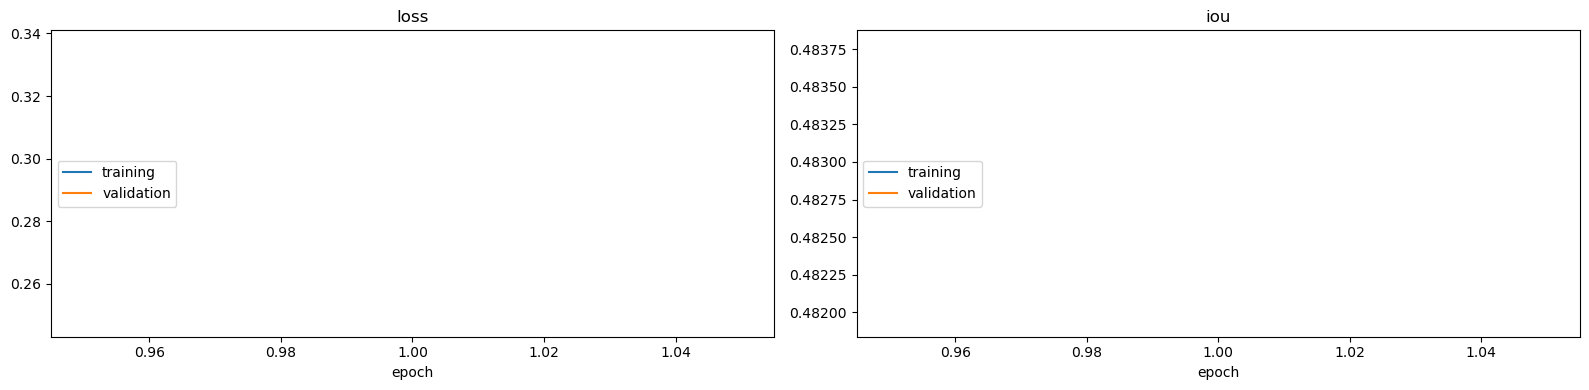

动态保存模块待命中
inf
保存位置: C:\project\python\GP_wei\encoder\model-weights_dur.hdf5

Saved epoch 1 model_1/model_2 at val_loss=0.3365

Epoch 2/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


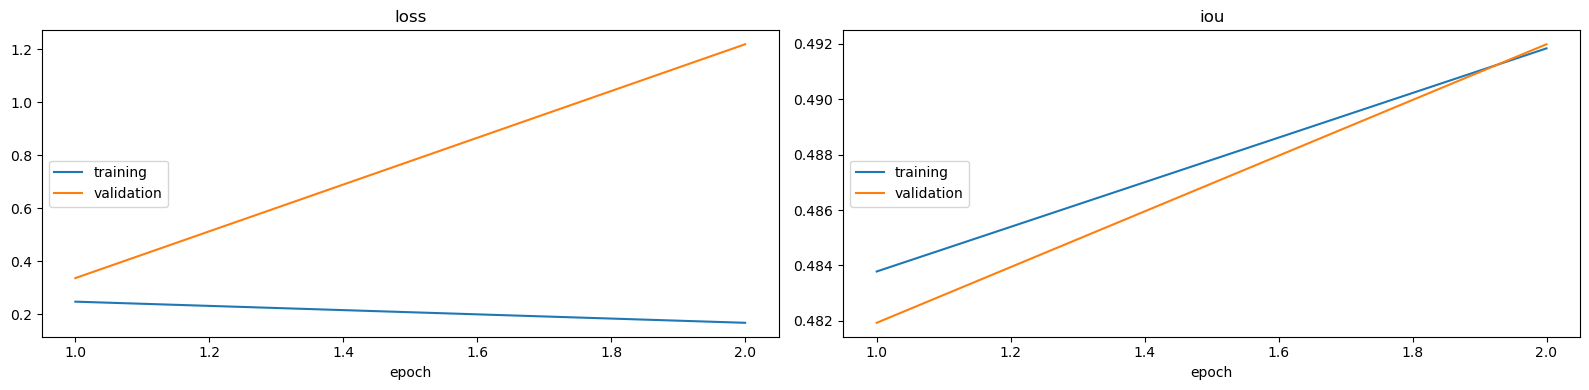

动态保存模块待命中
tf.Tensor(0.336542, shape=(), dtype=float32)

Epoch 3/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


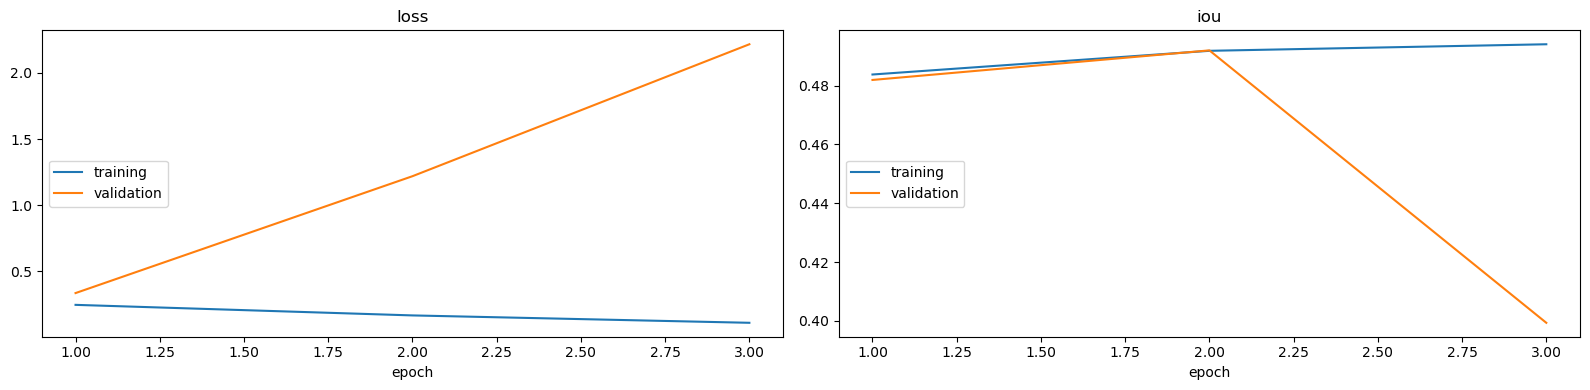

动态保存模块待命中
tf.Tensor(0.336542, shape=(), dtype=float32)

训练结束


In [18]:
# 训练1
train_generator1, val_generator1 = get_train_val_augmented1(imgDir=imgDir, 
                                                            batch_size_train=batch_size_train, 
                                                            batch_size_val=batch_size_val, 
                                                            seed=seed)
custom_checkpoint_1 = CustomModelCheckpoint(
    model_1 = encoder_model,
    model_2 = decoder_main,
    model_1_path=encFile,
    model_2_path=dec1File,
    monitor='val_loss',
    save_best_only=True
)
callbacks_list_1 = [
    # 可视化回调
    plot_losses,
    # 动态学习率调整
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, patience=10
        ),
    # 模型动态保存
    custom_checkpoint_1
]
trainingLoop_1 = CustomTrainingLoop( 
    callbacks_list = callbacks_list_1, 
    model = model_train_1, 
    optimizer = optimizer, 
    epochs = epochs, 
    train_generator = train_generator1, 
    val_generator = val_generator1, 
    steps_per_epoch_train = steps_per_epoch_train, 
    steps_per_epoch_val = steps_per_epoch_val, 
    loss_fn = task1_loss, 
    model_1=encoder_model, 
    model_2=decoder_main, 
)
trainingLoop_1.run()

动态保存模块初始化完成
self.model.metrics_names: []

Epoch 1/3
Found 634 images belonging to 5 classes.
Found 634 images belonging to 5 classes.
训练阶段done
Found 273 images belonging to 5 classes.
Found 273 images belonging to 5 classes.
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


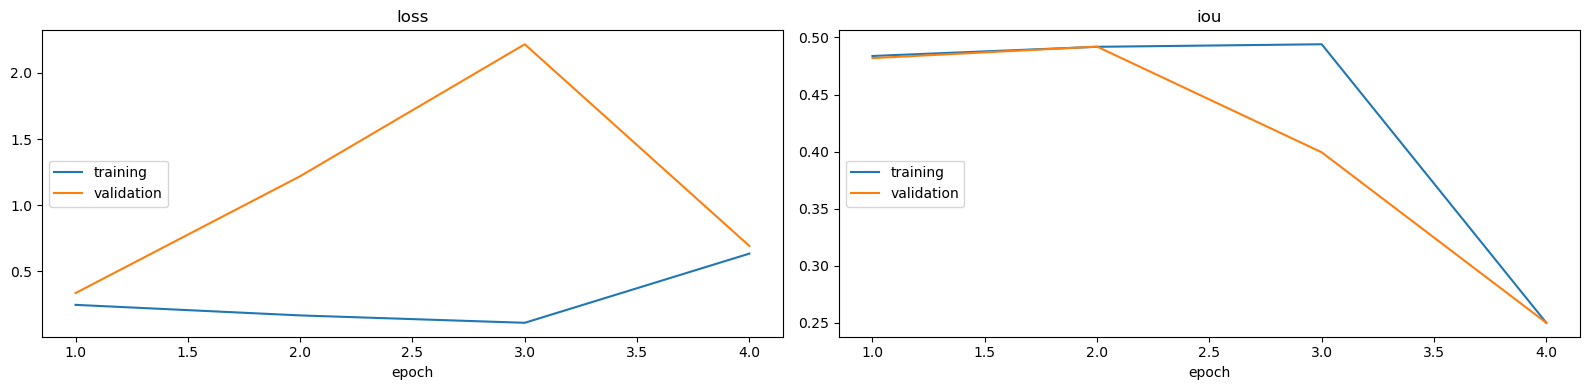

动态保存模块待命中
inf
保存位置: C:\project\python\GP_wei\decoder2\model-weights_dur.hdf5

Saved epoch 1 model_1/model_2 at val_loss=0.6924

Epoch 2/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


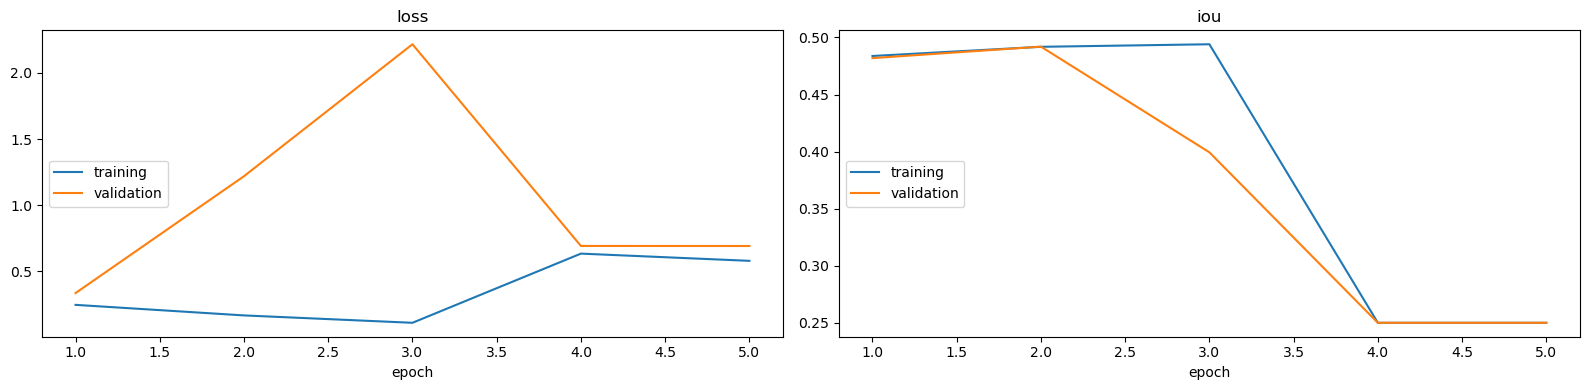

动态保存模块待命中
tf.Tensor(0.6923708, shape=(), dtype=float32)
保存位置: C:\project\python\GP_wei\decoder2\model-weights_dur.hdf5

Saved epoch 2 model_1/model_2 at val_loss=0.6922

Epoch 3/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


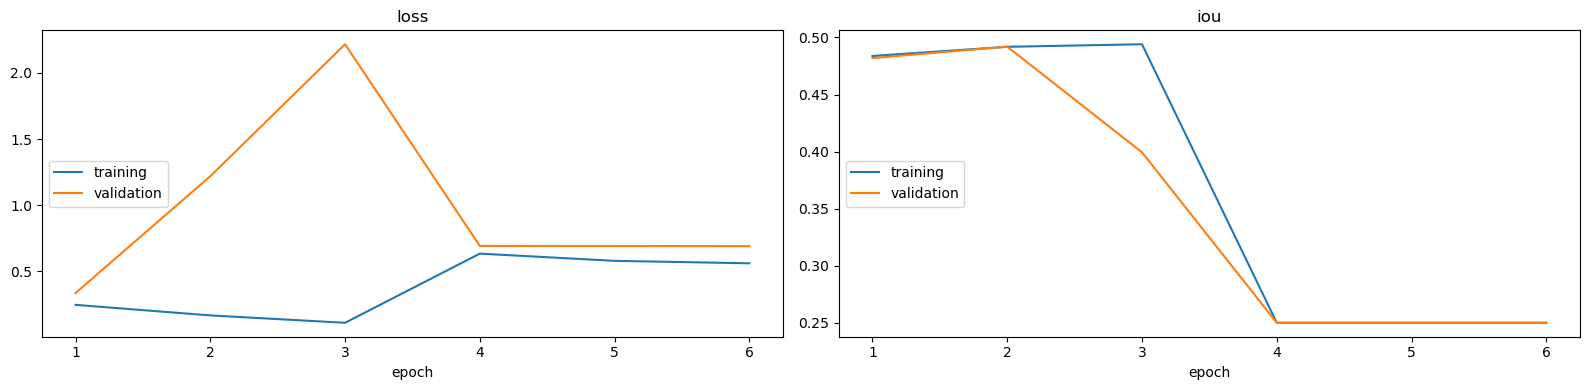

动态保存模块待命中
tf.Tensor(0.6921686, shape=(), dtype=float32)
保存位置: C:\project\python\GP_wei\decoder2\model-weights_dur.hdf5

Saved epoch 3 model_1/model_2 at val_loss=0.6911

训练结束


In [19]:
# 训练2

encoder_model.load_weights(encFile)


train_generator2, val_generator2 = get_train_val_augmented2(imgDir=imgDir, 
                                                            batch_size_train=batch_size_train, 
                                                            batch_size_val=batch_size_val, 
                                                            seed=seed)
custom_checkpoint_2 = CustomModelCheckpoint(
    model_1=decoder_bypass,
    model_1_path=dec2File, 
    monitor='val_loss',
    save_best_only=True
)
callbacks_list_2 = [
    # 可视化回调
    plot_losses,
    # 动态学习率调整
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, patience=10
        ),
    # 模型动态保存
    custom_checkpoint_2
]
trainingLoop_2 = CustomTrainingLoop( 
    callbacks_list = callbacks_list_2, 
    model = model_train_2, 
    optimizer = optimizer, 
    epochs = epochs, 
    train_generator = train_generator2, 
    val_generator = val_generator2, 
    steps_per_epoch_train = steps_per_epoch_train, 
    steps_per_epoch_val = steps_per_epoch_val, 
    loss_fn = task2_loss, 
    model_1=decoder_bypass,  
)
trainingLoop_2.run()

动态保存模块初始化完成
self.model.metrics_names: []

Epoch 1/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


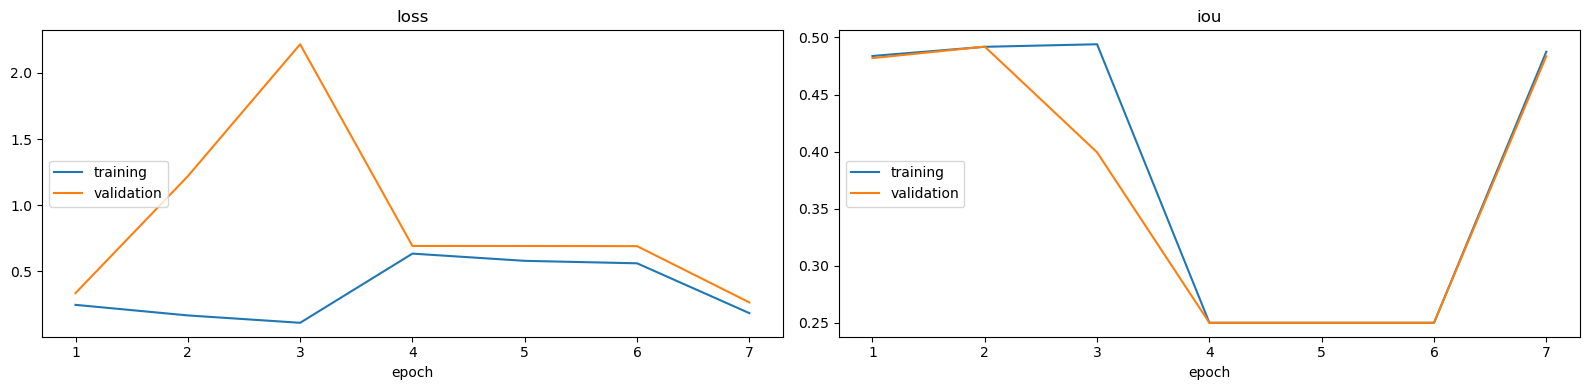

动态保存模块待命中
inf
保存位置: C:\project\python\GP_wei\fusion\model-weights_dur.hdf5

Saved epoch 1 model_1/model_2 at val_loss=0.2659

Epoch 2/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


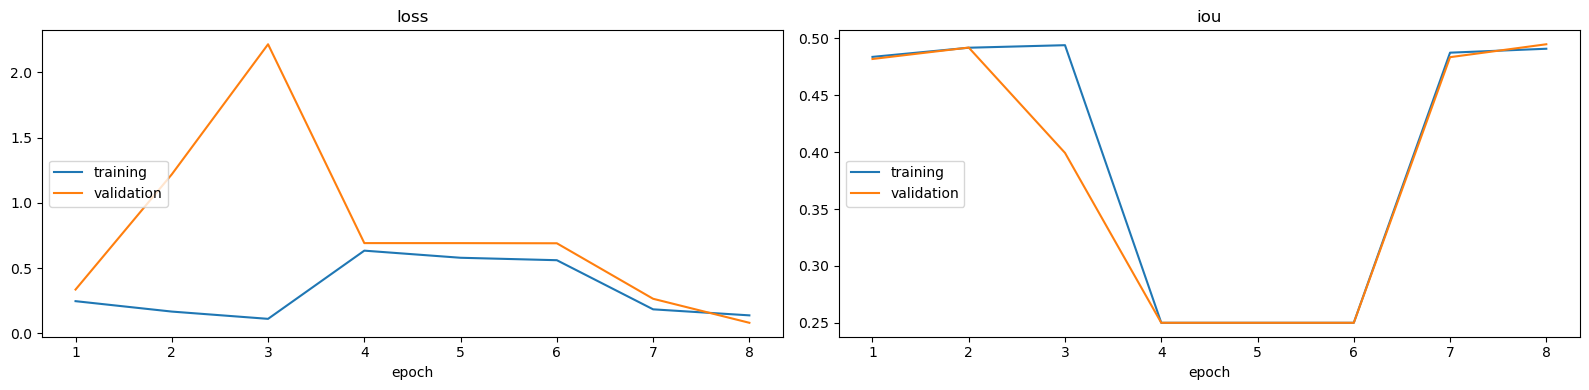

动态保存模块待命中
tf.Tensor(0.2658892, shape=(), dtype=float32)
保存位置: C:\project\python\GP_wei\fusion\model-weights_dur.hdf5

Saved epoch 2 model_1/model_2 at val_loss=0.0819

Epoch 3/3
训练阶段done
验证阶段done
self.metrics: ['loss', 'iou']
self.base_metrics: ['loss', 'iou']


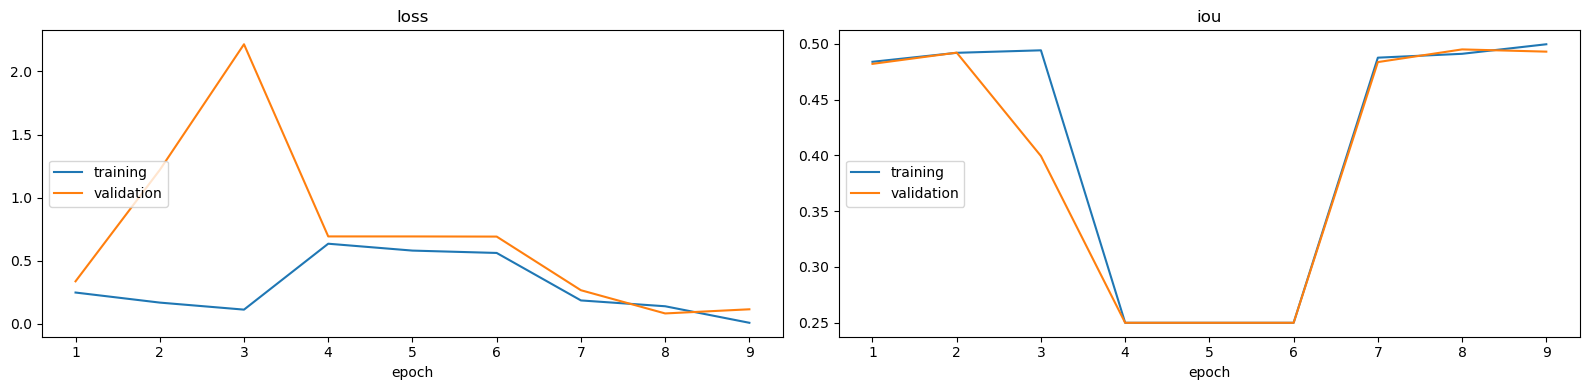

动态保存模块待命中
tf.Tensor(0.08188222, shape=(), dtype=float32)

训练结束


In [20]:
# 训练3
encoder_model.load_weights(encFile)
decoder_main.load_weights(dec1File)
decoder_bypass.load_weights(dec2File)

custom_checkpoint_3 = CustomModelCheckpoint(
    model_1=fusion_model,
    model_1_path=fusFile, 
    monitor='val_loss',
    save_best_only=True
)
callbacks_list_3 = [
    # 可视化回调
    plot_losses,
    # 动态学习率调整
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, patience=10
        ),
    # 模型动态保存
    custom_checkpoint_3
]
trainingLoop_3 = CustomTrainingLoop( 
    callbacks_list = callbacks_list_3, 
    model = model_train_3, 
    optimizer = optimizer, 
    epochs = epochs, 
    train_generator = train_generator1, 
    val_generator = val_generator1, 
    steps_per_epoch_train = steps_per_epoch_train, 
    steps_per_epoch_val = steps_per_epoch_val, 
    loss_fn = task3_loss, 
    model_1=fusion_model, 
)
trainingLoop_3.run()

In [21]:
#训练集数据读取器
def get_test_generator(imgDir=imgDir, batch_size_test=16, seed=seed):

    # 数据路径配置

    X_test_path = os.path.join(imgDir, "stage1_test", "images")# 测试图像路径
    Y_test_path = os.path.join(imgDir, "stage1_test", "segmentations")# 测试分割标签路径

    # 验证数据生成器（不进行数据增强）
    X_datagen_test = ImageDataGenerator()
    Y_datagen_test = ImageDataGenerator()

    def test_generator_fn(seed=seed, X_datagen_test=X_datagen_test, 
                          Y_datagen_test=Y_datagen_test, Y_test_path=Y_test_path, X_test_path = X_test_path):

        # 图像流
        X_test_augmented = X_datagen_test.flow_from_directory(X_test_path, 
                                                             target_size=(img_height, img_width), class_mode=None,
                                                             color_mode="rgb", batch_size=batch_size_test, shuffle=True, seed=seed)
        # 标签流
        Y_test_augmented = Y_datagen_test.flow_from_directory(Y_test_path, 
                                                             target_size=(img_height, img_width),class_mode="categorical",#生成标签数据
                                                             color_mode="grayscale", batch_size=batch_size_test, shuffle=True,
                                                             seed=seed)
        while True:
            X_testi = X_test_augmented.next()
            Y_testi1 = Y_test_augmented.next()
            X_testi = np.array(X_testi, dtype=np.uint8)
            Y_testi, C_testi = Y_testi1
            Y_testi = np.array(Y_testi, dtype=np.bool_)
            
            C_testi_expanded = C_testi[:, np.newaxis, np.newaxis, :]
            C_testi_expanded = np.array(C_testi_expanded, dtype=np.bool_)
            Y_testi = Y_testi * C_testi_expanded
            #result
            Y_testi = np.array(Y_testi, dtype=np.float32)# 如无意外不用这条代码，Y_testi也是float32
            yield X_testi, Y_testi


    
    # combine generators into one which yields image and masks
    test_generator = test_generator_fn(seed=seed, X_datagen_test=X_datagen_test, 
                                       Y_datagen_test=Y_datagen_test, Y_test_path=Y_test_path, 
                                       X_test_path = X_test_path)

    return test_generator #输出生成器


In [22]:
#import tensorflow as tf
#import numpy as np
#import pandas as pd

class SegNetEvaluator:
    def __init__(self,
                 test_generator, 
                 model1_name = "model1",
                 model2_name = "model2",
                 #model3_name = "model3",
                 model_1 = None,
                 model_2 = None,
                 steps_per_epoch_test = 1

                ):
        self.test_generator = test_generator
        self.model1_name = model1_name
        self.model2_name = model2_name
        #self.model3_name = model3_name
        self.model_1 = model_1
        self.model_2 = model_2
        self.steps_per_epoch_test = steps_per_epoch_test
        self.test_iou1 = keras.metrics.MeanIoU(num_classes=5, name='test_iou1')
        self.test_iou2 = keras.metrics.MeanIoU(num_classes=5, name='test_iou2')
        # 将模型名称与对应指标绑定
        self.model_configs = [
            (self.model1_name, self.test_iou1),
            (self.model2_name, self.test_iou2),
        ]

        
    def run(self):
        # 测试阶段
        self.test_iou1.reset_states()
        self.test_iou2.reset_states()
        for step in range(self.steps_per_epoch_test):
            X_batch, Y_batch = next(self.test_generator)  # 获取训练批次
            self._test_step(X_batch, Y_batch)
            print("测试阶段done")

        self._show()
        
            
    def _test_step(self, inputs, labels_task):#训练开始
        outputs_task1 = self.model_1(inputs, training=False)
        # 更新IOU指标
        self.test_iou1.update_state(labels_task, outputs_task1)
        print(self.test_iou1.result())
        outputs_task2 = self.model_2(inputs, training=False)
        # 更新IOU指标
        self.test_iou2.update_state(labels_task, outputs_task2)
        print(self.test_iou2.result())

    def _show(self):
        results = []
        # 遍历配置并获取实际指标值
        for name, metric in self.model_configs:
            iou_value = metric.result().numpy()
            results.append({
                "Model": name,
                "IoU": round(iou_value, 5)  # 四舍五入保留4位小数
            })
        
        # 用DataFrame展示结果
        print(pd.DataFrame(results).to_markdown(index=False))
    




In [23]:
#对比
encoder_model.load_weights(encFile)
decoder_main.load_weights(dec1File)
decoder_bypass.load_weights(dec2File)
fusion_model.load_weights(fusFile)
print("load:done")
test_generator = get_test_generator(imgDir=imgDir, batch_size_test=16, seed=seed)

evaluator = SegNetEvaluator(
    test_generator=test_generator,
    model_1=model_train_1,  # 实际模型实例
    model_2=model_train_3,  # 实际模型实例
    steps_per_epoch_test = steps_per_epoch_test  # 确保遍历整个数据集
)
evaluator.run()

load:done
Found 273 images belonging to 5 classes.
Found 273 images belonging to 5 classes.
tf.Tensor(0.48795786, shape=(), dtype=float32)
tf.Tensor(0.48795786, shape=(), dtype=float32)
测试阶段done
| Model   |     IoU |
|:--------|--------:|
| model1  | 0.48796 |
| model2  | 0.48796 |


In [24]:
from keras_flops import get_flops
flops = get_flops(model_train_1, batch_size=1)
print(f"FLOPS: {flops / 1e9:.2f} GFLOPS")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 106.68 GFLOPS


In [25]:
flops = get_flops(model_train_3, batch_size=1)
print(f"FLOPS: {flops / 1e9:.2f} GFLOPS")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
FLOPS: 173.19 GFLOPS


总参数量：48910345


In [28]:
model_train_1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 512)         14731584  
_________________________________________________________________
decoder_decoder_main (Functi (None, 256, 256, 5)       17089477  
Total params: 31,821,061
Trainable params: 31,804,165
Non-trainable params: 16,896
_________________________________________________________________


In [29]:
model_train_3.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 8, 8, 512)    14731584    input_1[0][0]                    
__________________________________________________________________________________________________
decoder_decoder_main (Functiona (None, 256, 256, 5)  17089477    encoder[0][0]                    
__________________________________________________________________________________________________
decoder_decoder_bypass (Functio (None, 256, 256, 2)  17089282    encoder[0][0]                    
_______________________________________________________________________________________

In [26]:
total_params = model_train_1.count_params()
print(f"总参数量：{total_params}")  # 输出整数形式的总参数值
total_params = model_train_3.count_params()
print(f"总参数量：{total_params}")  # 输出整数形式的总参数值

总参数量：31821061


In [30]:
tf.keras.utils.plot_model(model_train_1, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
tf.keras.utils.plot_model(model_train_3, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
